[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vectorizing the text data...
Silhouette Score: 0.13229987025260925
Davies-Bouldin Index: 5.288056910683533
Calinski-Harabasz Index: 491.5079172008775
0.13020931
0.09517173
0.07290628
0.074082375
0.082304835
0.076638065
0.09206033
0.054029416
0.061515056
0.07912065
0.05744641
0.053713206
0.067276716
0.07713708
0.060392637
0.029960731
0.05124055
0.046317495
0.054884616


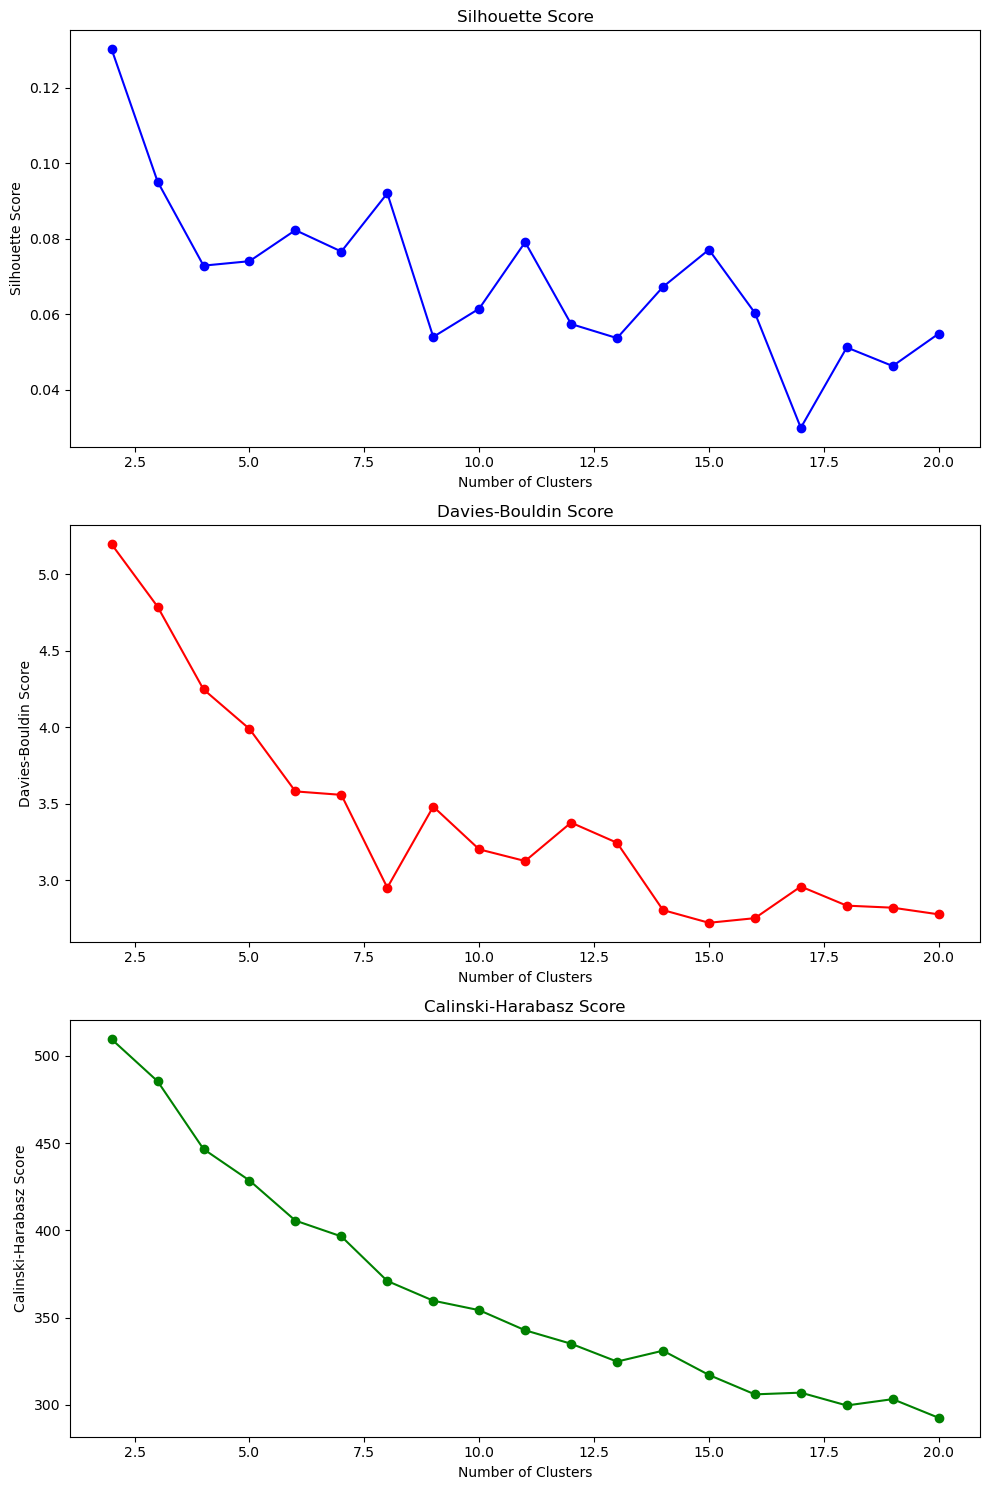

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string


# In[2]:


newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)


# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

# Apply preprocessing to each document in the dataset
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')


# In[3]:


import warnings
warnings.filterwarnings("ignore")
# Initialize centroids with KMeans
def initialize_centroids(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans.cluster_centers_

# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia_and_labels(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia, labels


# Firefly movement (simplified)
def move_towards_brighter(firefly_i, firefly_j, beta0=1, gamma=1):
    distance = np.linalg.norm(firefly_i - firefly_j)
    beta = beta0 * np.exp(-gamma * distance**2)  # attractiveness
    step = beta * (firefly_j - firefly_i)
    new_position = firefly_i + step
    return new_position

class Particle:
    def __init__(self, data, n_clusters):
        self.position = initialize_centroids(data, n_clusters)
        self.velocity = np.zeros_like(self.position)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

    def update_velocity(self, global_best_position, w=0.5, c1=1, c2=1):
        r1, r2 = np.random.rand(), np.random.rand()
        self.velocity = w * self.velocity + c1 * r1 * (self.best_position - self.position) + c2 * r2 * (global_best_position - self.position)

    def update_position(self, data_bounds):
        self.position += self.velocity
        # Clip the positions so they stay within the data bounds
        self.position = np.clip(self.position, data_bounds[0], data_bounds[1])

def pso_firefly_kmeans(data, n_clusters, n_particles=10, max_iter=100, kmeans_interval=20):
    particles = [Particle(data, n_clusters) for _ in range(n_particles)]
    global_best_score = float('inf')
    global_best_position = None

    data_bounds = np.array([data.min(axis=0), data.max(axis=0)])

    for i in range(max_iter):
        for particle in particles:
            inertia, _ = compute_inertia_and_labels(particle.position, data)
            if inertia < particle.best_score:
                particle.best_score = inertia
                particle.best_position = np.copy(particle.position)
            if inertia < global_best_score:
                global_best_score = inertia
                global_best_position = np.copy(particle.position)

        # PSO update
        for particle in particles:
            particle.update_velocity(global_best_position)
            particle.update_position(data_bounds)

        # Firefly update
        for particle_i in particles:
            for particle_j in particles:
                if particle_j.best_score < particle_i.best_score:  # If j is brighter than i
                    particle_i.position = move_towards_brighter(particle_i.position, particle_j.best_position)

        # KMeans refinement at specified intervals
        if i % kmeans_interval == 0 and i != 0:
            # Using current global best as initial centroids for KMeans refinement
            kmeans = KMeans(n_clusters=n_clusters, init=global_best_position, n_init=1)
            kmeans.fit(data)
            refined_centroids = kmeans.cluster_centers_

            # Update global best if KMeans refinement improves inertia
            refined_inertia, _ = compute_inertia_and_labels(refined_centroids, data)
            if refined_inertia < global_best_score:
                global_best_score = refined_inertia
                global_best_position = refined_centroids

    final_labels = compute_inertia_and_labels(global_best_position, data)[1]
    return global_best_position, final_labels, global_best_score

# Assuming 'data' is your dataset and 'n_clusters' is the desired number of clusters
best_centroids, labels, best_score = pso_firefly_kmeans(tfidf_matrix_reduced, n_clusters=2)
# print("Best Score (Inertia):", best_score)
# Calculate and print the clustering metrics
silhouette = silhouette_score(tfidf_matrix_reduced, labels)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, labels)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, labels)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


# In[4]:


from sklearn.decomposition import PCA
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans = KMeans(n_clusters)
    kmeans.fit(tfidf_matrix_reduced)
    labels=kmeans.labels_

    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, labels)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced,labels)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced,labels)

    # Store metrics
    silhouette_scores.append(silhouette)
    print(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)


# In[5]:


import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_count-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_count-Kmeans.png")
plt.tight_layout()
plt.show()


# In[6]:


import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))


# In[7]:


df


# In[8]:


df.to_csv('TFIDF_PSO+Firefly_Scores.csv')


# In[ ]:




